In [1]:
#TODO: changeme
%cd /Users/janne/git/tutorial/codes
# from codes.data_loader import GTZANLoader

/Users/janne/git/tutorial/codes


In [2]:
# loader = GTZANLoader(data_path="./data", split="TRAIN", num_chunks=8, input_length=None)

# Audio Data Augmentations

```
Audio = CHANNEL x SAMPLES
```

In [8]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
from utils import plot_spectrogram

In [13]:
from torchaudio.datasets import GTZAN
dataset = GTZAN(root=".", download=True)

audio, sr, genre = dataset[0]
print(f"Genre: {genre}\nSample rate: {sr}\nChannels: {audio.shape[0]}\nSamples: {audio.shape[1]}")
display(Audio(audio, rate=sr))

Genre: rock
Sample rate: 22050
Channels: 1
Samples: 661794


### Augmentation Modules

In [15]:
from torchaudio_augmentations import Compose, ComposeMany
from torchaudio_augmentations import (
    Delay,
    Gain,
    HighLowPass,
    Noise,
    PitchShift,
    PolarityInversion,
    RandomResizedCrop,
    Reverb,
)

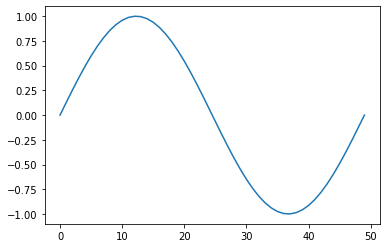

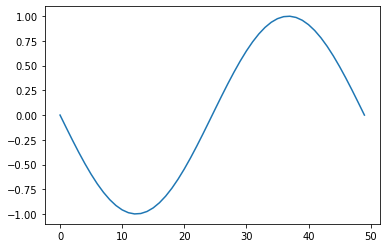

In [16]:
import math
l = 1/440.0
test_audio = torch.sin(math.tau * 440.0 * torch.linspace(0, l, int(l*sr))).unsqueeze(0)
plt.plot(test_audio.squeeze(0))
plt.show()


inverted_test_audio = PolarityInversion()(test_audio)
plt.plot(inverted_test_audio.squeeze(0))
plt.show()

### Compose Module

In [17]:
transform = Compose([
    Delay(
        sample_rate=sr,
        volume_factor=0.5,
        min_delay=100,
        max_delay=500,
        delay_interval=1,
    )])

print("Transform:", transform)
transformed_audio = transform(audio)
display(Audio(audio, rate=sr))
display(Audio(transformed_audio, rate=sr))

Transform: Compose(
	Delay()
)


### Stack audio augmentations

In [18]:
# 4 seconds of audio
num_samples = sr * 4

transforms = [
    RandomResizedCrop(n_samples=num_samples),
    HighLowPass(
        sample_rate=sr,
        lowpass_freq_low=2200,
        lowpass_freq_high=4000,
        highpass_freq_low=200,
        highpass_freq_high=1200,
    ),
    Delay(
        sample_rate=sr,
        volume_factor=0.5,
        min_delay=100,
        max_delay=500,
        delay_interval=1,
    )
]
transform = Compose(transforms)

print("Transform:", transform)
transformed_audio = transform(audio)

display(Audio(transformed_audio, rate=sr))

Transform: Compose(
	RandomResizedCrop()
	HighLowPass()
	Delay()
)


### Return multiple augmented samples

Transform: ComposeMany(
	RandomResizedCrop()
	HighLowPass()
	Delay()
)


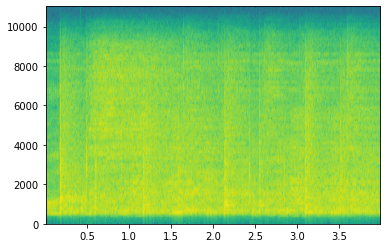

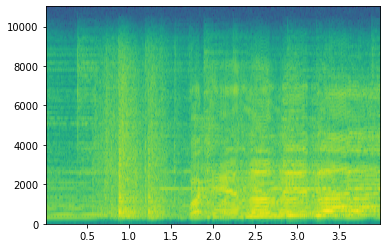

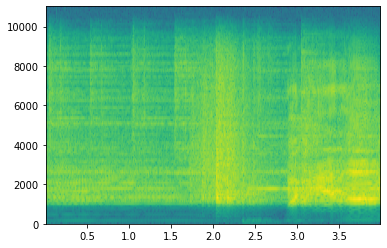

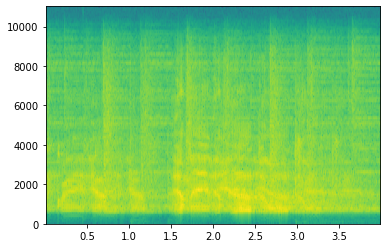

In [20]:
# we want 4 augmented samples from ComposeMany
num_augmented_samples = 4

transform = ComposeMany(transforms, num_augmented_samples=num_augmented_samples)

print("Transform:", transform)
transformed_audio = transform(audio)
for ta in transformed_audio:
    plot_spectrogram(ta, sr, title="")
    display(Audio(ta, rate=sr))
plt.show()

## Stochastic Audio Data Augmentations

In [ ]:
transforms = [
    PolarityInversion(),
    PitchShift(sample_rate=sr, n_samples=audio.shape[1]),
    Reverb(sample_rate=sr)
]

stochastic_transforms = [
    RandomApply(transforms, p=0.5)
]
transform = Compose(stochastic_transforms)
print(transform)
transformed_audio = transform(audio)
display(Audio(transformed_audio, rate=sr))

### Audio chain stochastic augmentations

In [21]:
from torchaudio_augmentations import RandomApply

# we want 4 augmented samples from ComposeMany
num_augmented_samples = 4

# 4 seconds of audio
num_samples = sr * 4

stochastic_transforms = [
    RandomResizedCrop(n_samples=num_samples),
    
    # apply with p = 0.3
    RandomApply([
            PolarityInversion(),
            HighLowPass(
                sample_rate=sr,
                lowpass_freq_low=2200,
                lowpass_freq_high=4000,
                highpass_freq_low=200,
                highpass_freq_high=1200,
            ),
            Delay(
                sample_rate=sr,
                volume_factor=0.5,
                min_delay=100,
                max_delay=500,
                delay_interval=1,
            ),
        ], 
        p=0.3),
    
    # apply with p = 0.8
    RandomApply([
            PitchShift(sample_rate=sr, n_samples=num_samples),
            Gain(),
            Noise(max_snr=0.01),
            Reverb(sample_rate=sr)
        ],
        p=0.8)
]
transform = ComposeMany(stochastic_transforms, num_augmented_samples=num_augmented_samples)

print("Transform:", transform)

for ta in transformed_audio:
    display(Audio(ta, rate=sr))
plt.show()

Transform: ComposeMany(
	RandomResizedCrop()
	RandomApply(
    p=0.3
    PolarityInversion()
    HighLowPass()
    Delay()
)
	RandomApply(
    p=0.8
    Gain()
    Noise()
    Reverb()
)
)


### Single stochastic augmentations

Transform: ComposeMany(
	RandomResizedCrop()
	RandomApply(
    p=0.8
    PolarityInversion()
)
	RandomApply(
    p=0.6
    HighLowPass()
)
	RandomApply(
    p=0.6
    Delay()
)
	RandomApply(
    p=0.3
)
	RandomApply(
    p=0.6
    Gain()
)
	RandomApply(
    p=0.3
    Noise()
)
	RandomApply(
    p=0.5
    Reverb()
)
)


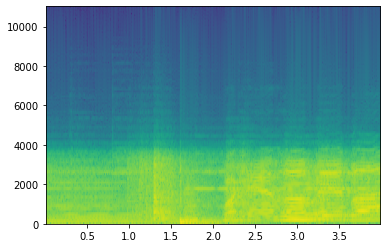

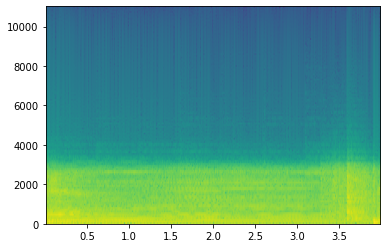

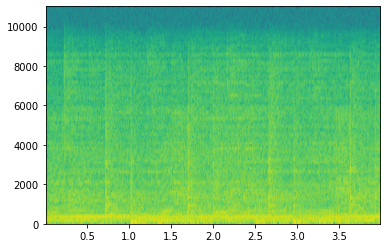

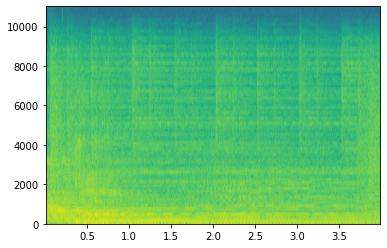

In [23]:
# we want 4 augmented samples from ComposeMany
num_augmented_samples = 4

# 4 seconds of audio
num_samples = sr * 4


# define our stochastic augmentations
transforms = [
    RandomResizedCrop(n_samples=num_samples),
    RandomApply([PolarityInversion()], p=0.8),
    RandomApply([HighLowPass(sample_rate=sr)], p=0.6),
    RandomApply([Delay(sample_rate=sr)], p=0.6),
    RandomApply([PitchShift(sample_rate=sr, n_samples=num_samples)], p=0.3),
    RandomApply([Gain()], p=0.6),
    RandomApply([Noise(max_snr=0.01)], p=0.3),
    RandomApply([Reverb(sample_rate=sr)], p=0.5)
]


transform = ComposeMany(transforms, num_augmented_samples=num_augmented_samples)

print("Transform:", transform)
transformed_audio = transform(audio)

for ta in transformed_audio:
    plot_spectrogram(ta, sr, title=e="")
    display(Audio(ta, rate=sr))
plt.show()